In [3]:
import cv2
import imutils
import numpy as np
import os
import pandas as pd

from tqdm import tqdm
from glob import glob
from albumentations import RandomCrop, HorizontalFlip, VerticalFlip

from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.pyplot as plt


import os


In [3]:
LOCAL: bool = True # I optionally use ": bool" when declaring variables to indicate which type they are

if LOCAL:
    pred_path = r"C:\Users\pedri\Desktop"
    actual_path = r"C:\Users\pedri\Desktop"
else: 
    pred_path = os.path.relpath(os.getcwd(),r"Segmentation")
    actual_path = os.path.relpath(os.getcwd(), r"Segmentation\data\drone_pics" )
    

img = os.path.join(pred_path, "real_pred.jpg")
act = os.path.join(actual_path, "drone_pic.PNG")

x = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
y = cv2.imread(act, cv2.IMREAD_COLOR)


if x is None or y is None:
    raise Exception("No image has been read! Check your path name.")


In [6]:
DEBUG: bool = True

H = 320
W = 480

y = cv2.resize(y, (W, H))


labels = ["paved-area",
        "dirt",
        "grass",
        "gravel",
        "water",
        "rocks",
        "pool",
        "vegetation",
        "roof",
        "wall",
        "window",
        "door",
        "fence",
        "fence-pole",
        "person",
        "dog",
        "car",
        "bicycle",
        "tree",
        "bald-tree",
        "ar-marker",
        "obstacle",
        "conflicting",
]
div = 255 / len(labels)
thresh = [(1 + div*i, (i + 1)*div) for i in range(len(labels))]
new_list = zip(thresh, labels)

if DEBUG: print(thresh)

thresh_tuple = [cv2.threshold(x, thresh[i][0], thresh[i][1], cv2.THRESH_BINARY) for i in range(len(thresh))]

mask = [cv2.bitwise_and(x, x, mask = thresh_tuple[i][1]) for i in range(len(thresh_tuple))]
mask = [cv2.erode(mask[i], None, iterations = 4) for i in range(len(mask))]
mask = [cv2.dilate(mask[i], None, iterations = 4) for i in range(len(mask))]
mask = [mask[i].astype(np.uint8) for i in range(len(mask))]
#mask = [cv2.cvtColor(mask[i], cv2.COLOR_BGR2GRAY) for i in range(len(mask))]
print(type(mask[0]))
if DEBUG: 
        cv2.imshow("Mask", mask[0])
        cv2.waitKey(0)
        cv2.destroyAllWindows()


[(1.0, 11.08695652173913), (12.08695652173913, 22.17391304347826), (23.17391304347826, 33.26086956521739), (34.26086956521739, 44.34782608695652), (45.34782608695652, 55.434782608695656), (56.434782608695656, 66.52173913043478), (67.52173913043478, 77.60869565217392), (78.60869565217392, 88.69565217391305), (89.69565217391305, 99.78260869565217), (100.78260869565217, 110.86956521739131), (111.86956521739131, 121.95652173913044), (122.95652173913044, 133.04347826086956), (134.04347826086956, 144.1304347826087), (145.1304347826087, 155.21739130434784), (156.21739130434784, 166.30434782608697), (167.30434782608697, 177.3913043478261), (178.3913043478261, 188.47826086956522), (189.47826086956522, 199.56521739130434), (200.56521739130434, 210.6521739130435), (211.6521739130435, 221.73913043478262), (222.73913043478262, 232.82608695652175), (233.82608695652175, 243.91304347826087), (244.91304347826087, 255.0)]
<class 'numpy.ndarray'>


In [7]:
for i in range(len(mask)):
    cnts = cv2.findContours(mask[i].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    center = None
    cX = None
    cY = None
    min_size = 20

    if DEBUG: print(len(cnts))

    for c in cnts:
        ((cx, cy), radius) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)
        center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))
        (cX, cY) = center
        
        if radius > min_size:
            text = f"{labels[i]}"
            y = cv2.putText(img = y, 
                            text = text, 
                            org = (cX, cY - 15),
                            fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                            fontScale = 0.5, 
                            color = (255, 255, 255), 
                            thickness = 2)


1
11
11
16
11
12
12
12
8
9
9
9
9
9
9
9
9
9
9
9
9
9
0


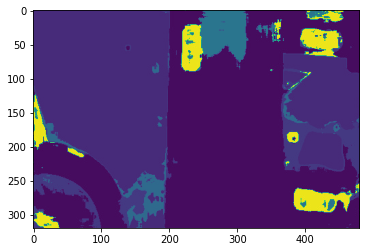

In [8]:

plt.figure()
plt.imshow(x)


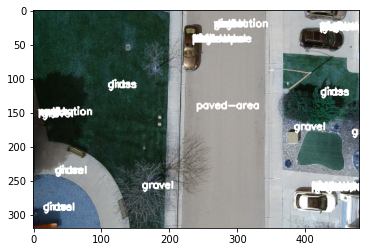

In [9]:
plt.figure()
plt.imshow(y)


[Text(1, 11.0, 'paved-area'),
 Text(1, 33.0, 'grass'),
 Text(1, 55.0, 'water'),
 Text(1, 77.0, 'pool'),
 Text(1, 99.00000000000001, 'roof'),
 Text(1, 121.00000000000001, 'window'),
 Text(1, 144.0, 'fence'),
 Text(1, 166.0, 'person'),
 Text(1, 187.99999999999997, 'car'),
 Text(1, 209.99999999999997, 'tree'),
 Text(1, 232.00000000000003, 'ar-marker'),
 Text(1, 255.0, 'conflicting')]

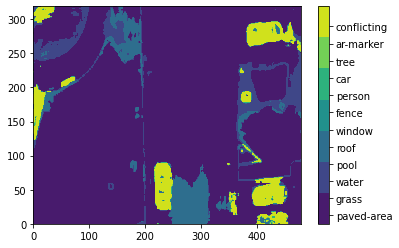

In [63]:
fig = plt.figure()
plt.contourf(x)
cbar = plt.colorbar (ticks = [int(thresh[i][1]) for i in range(0, len(thresh), 2)], orientation = 'vertical')
cbar.ax.set_yticklabels( [labels[i] for i in range(0, len(thresh), 2)])#[labels[i] in range(0, len(thresh), 1)])

# Make Predictions on our own dataset

In [1]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback
from tensorflow.keras.utils import plot_model
import os


# Show GPUs devices
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4632950654099195959
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3660972032
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7230040135322620735
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


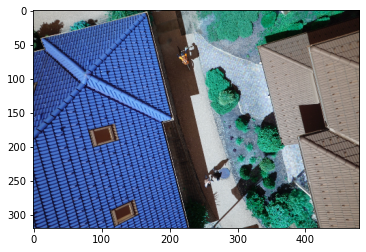

In [4]:
image_path = "../data/dataset/semantic_drone_dataset/new_data/images"
img = os.path.join(image_path, "145_0.jpg")
H = 320
W = 480
x = cv2.imread(img, cv2.IMREAD_COLOR)
x = cv2.resize(x, (W, H))
x = x/255.0
x = x.astype(np.float32)
plt.figure()
plt.imshow(x)
#plt.colorbar(label="Labels")

In [5]:
# Load Model
model = tf.keras.models.load_model("../results/models/model_11.h5")

In [6]:
p = model.predict(np.expand_dims(x, axis=0))[0]


In [7]:
p = np.argmax(p, axis=-1)
p = np.expand_dims(p, axis=-1)  
num_classes = 23
p = p * (255/num_classes)
p = p.astype(np.int32)
p = np.concatenate([p, p, p], axis=2)

In [8]:
cv2.imwrite(f"../results/145.png", p)

True

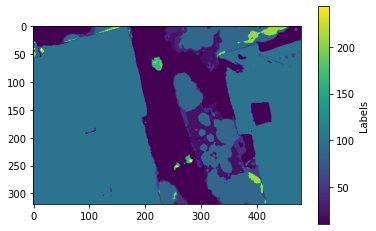

In [10]:
pred = cv2.imread("../results/145.png", cv2.IMREAD_GRAYSCALE)

plt.imshow(pred)
plt.colorbar(label="Labels")

In [28]:
p.shape

(320, 480, 3)

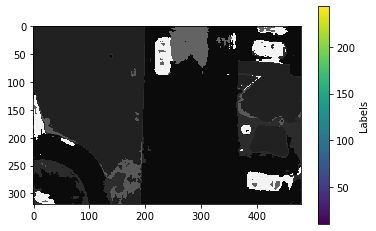

In [23]:
plt.imshow(p, interpolation = 'nearest')
plt.colorbar(label="Labels")